<a href="https://colab.research.google.com/github/dmbk/Anomaly-Detection-System/blob/master/FINAL_MODEL_AAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imageio
!pip install progress
#!pip install tensorflow_datasets
!pip install keras-layer-normalization
from google.colab import drive
#!pip install alive-progress
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import skimage
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from os.path import join
from os import listdir
from os.path import isfile, join, isdir

#import keras
import argparse
from os.path import dirname
import cv2
from google.colab.patches import cv2_imshow
	
import statistics
import shutil

import matplotlib.pyplot as plt

import time
from progress.bar import IncrementalBar

import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, Dropout, Activation, InputLayer
from keras.optimizers import Adam
from keras_layer_normalization import LayerNormalization


Using TensorFlow backend.


In [0]:
class Config:
    def __init__(self, data_dir_, cwdir_name_, data_set):
        self.data_set_name = data_set
        self.data_dir = data_dir_
        self.data_set_dir = join(self.data_dir, data_set)
        self.cwdir_name = cwdir_name_
        self.cwdir = join(self.data_dir,self.cwdir_name)
        self.run_data = join(self.cwdir, "training_gan")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")
        if not os.path.exists(self.cwdir):
            os.mkdir(self.cwdir)
            os.mkdir(self.run_data)
    
        if not os.path.exists(self.run_data):
            #shutil.rmtree(self.run_data)
            os.mkdir(self.run_data)
            os.makedirs(self.image_dir, exist_ok=True)
            os.mkdir(self.ref_model_dir)

        self.DATASET_PATH = join(self.data_set_dir,"Train/")
        self.TEST_DIR = join(self.data_set_dir,"Test/")
        self.BATCH_SIZE = 2
        self.EPOCHS = 50
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = 0
        self.dim1 = 10
        self.dim2 = 256
        self.dim3 = 256
        self.dim4 = 1



    def reconfig(self, new_name, batch_size = 4, epochs = 5, retrain = 0):
        self.cwdir_name = new_name
        self.cwdir = join(self.data_dir, self.cwdir_name)
        self.run_data = join(self.cwdir, "training_dir")
        self.image_dir = join(self.run_data,self.data_set_name,"Test/")

        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.GEN_MODEL_PATH = join(self.cwdir,"model_gen_Conv2DLSTM_AAE")
        self.DIS_MODEL_PATH = join(self.cwdir,"model_dis_Conv2DLSTM_AAE")
        self.DEC_MODEL_PATH = join(self.cwdir,"model_dec_Conv2DLSTM_AAE")

        self.retrain = retrain
        if retrain == 0:
            print("Configuring train from scratch")
            if not os.path.exists(self.cwdir):
                os.mkdir(self.cwdir)
                os.mkdir(self.run_data)
    
            if os.path.exists(self.run_data):
                shutil.rmtree(self.run_data)
                os.mkdir(self.run_data)
                os.makedirs(self.image_dir, exist_ok=True)


conf = Config(data_dir_="/content/drive/My Drive/", cwdir_name_="Conv2DLSTM_AAE", data_set="UCSD_Anomaly_Dataset.v1p2/UCSDped1/") 


In [0]:
def get_clips_by_stride(stride, frames_list, sequence_size):

    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(clip)
                cnt = 0
    return clips

def get_clips_list(seq_size):

    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(conf.DATASET_PATH)):
        directory_path = join(conf.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32)
                    img = (img - 127.5)/127.5
                    #img = (2*(img - np.amin(img))/(np.amax(img) - np.amin(img)))-1
                    #img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 32-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=seq_size))
    
    #print(np.array(clips).shape)
    return np.array(clips)


def get_single_test(single_test_path, sz):
    test = np.zeros(shape=(sz, conf.dim2, conf.dim3, conf.dim4))
    cnt = 0
    for f in sorted(listdir(single_test_path)):
        if str(join(single_test_path, f))[-3:] == "tif":
            img = Image.open(join(single_test_path, f)).resize((conf.dim2, conf.dim3))
            #cv2_imshow(np.array(img,dtype=np.float32))
            #cv2.waitKey(0)
            img = np.array(img, dtype=np.float32) / 256
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

def get_test_sequences(test_case_dir, sz):
    test = get_single_test(join(conf.TEST_DIR,test_case_dir), sz)
    print("Test case loaded")
    sz = test.shape[0] - conf.dim1
    sequences = np.zeros((sz, conf.dim1, conf.dim2, conf.dim3, conf.dim4))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((conf.dim1, conf.dim2, conf.dim3, conf.dim4))
        for j in range(0, conf.dim1):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    return sequences

def convert_images_back(image):
    return np.reshape(image,(256, 256))*256.0
    #print(image.shape)
    #return np.reshape(image[:, :, 0],(image.shape[0], image.shape[1]))*127.5 + 127.5




In [0]:
def build_model_enc():
    if conf.retrain == 1 and os.path.isfile(conf.GEN_MODEL_PATH+".hdf5"):
        model_gen=load_model(conf.GEN_MODEL_PATH)
        return model_gen
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(8, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(2, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(Flatten())
    seq.summary(line_length=150)
    return  seq

def build_model_dec():
    if conf.retrain == 1 and os.path.isfile(conf.DEC_MODEL_PATH+".hdf5"):
        model_gen=load_model(conf.DEC_MODEL_PATH)
        return model_gen
    seq = Sequential()
    seq.add(Reshape((10, 32, 32, 2), input_shape=(20480,)))
    seq.add(ConvLSTM2D(2, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())

    seq.add(ConvLSTM2D(8, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    seq.summary(line_length=150)
    return seq

def build_model_disc():
    if conf.retrain == 1 and os.path.isfile(conf.DIS_MODEL_PATH+".hdf5"):
        model_gen=load_model(conf.DIS_MODEL_PATH)
        return model_gen
    seq = Sequential()
    model = Sequential()
    seq.add(Reshape((10, 32, 32, 2), input_shape=(20480,)))
    seq.add(TimeDistributed(Conv2D(32, (3, 3), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (3,3), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(128, (3,3), strides=4, padding="same")))
    seq.add(LayerNormalization())
    
    seq.add(Flatten())
    seq.add(Dense(512, activation="relu"))
    seq.add(Dropout(0.4))
    seq.add(Dense(256, activation="relu"))
    seq.add(Dropout(0.4))
    seq.add(Dense(128, activation="relu"))
    seq.add(Dropout(0.4))
    seq.add(Dense(64, activation="relu"))
    #model.add(ke.layers.Dense(32, activation="relu", input_shape=(20480,)))
    #model.add(ke.layers.Dense(32, activation="relu"))
    seq.add(Dense(1, activation="sigmoid"))
    seq.summary(line_length=150)
    return seq

#build_model_enc()
#build_model_dec()
#build_model_disc()

In [6]:
def build_model_aae():
    model_enc = build_model_enc()
    model_dec = build_model_dec()
    model_disc = build_model_disc()
    
    model_ae = Sequential()
    model_ae.add(model_enc)
    model_ae.add(model_dec)
    
    model_enc_disc = Sequential()
    model_enc_disc.add(model_enc)
    model_enc_disc.add(model_disc)
    
    return model_enc, model_dec, model_disc, model_ae, model_enc_disc

model_enc, model_dec, model_disc, model_ae, model_enc_disc = build_model_aae()

model_enc.summary()
model_dec.summary()
model_disc.summary()
model_ae.summary()
model_enc_disc.summary()

model_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_enc_disc.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy")
model_ae.compile(optimizer=Adam(lr=1e-3), loss="mean_squared_error")


Model: "sequential_1"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
time_distributed_1 (TimeDistributed)                               (None, 10, 64, 64, 128)                                     15616                  
______________________________________________________________________________________________________________________________________________________
layer_normalization_1 (LayerNormalization)                         (None, 10, 64, 64, 128)                                     256                    
______________________________________________________________________________________________________________________________________________________
time_distributed_2 (TimeDistributed)                               (None

In [0]:


def reconstruct_batch(model, sequences, epoch, folder_name):

    sz = sequences.shape[0]
    #InX = Input(shape=sequences.shape[1:]) 
    #tmpModel = Model(inputs=InX, outputs=model.get_layer("convTD5").output)
    reconstructed_sequences = model.predict(sequences,batch_size=conf.BATCH_SIZE)

    path = join(conf.run_data,folder_name, str(epoch)+"_epoch")
    os.makedirs(path, exist_ok=True)
    for i in range(0, sz):
        #cv2_imshow(np.reshape(reconstructed_sequences[i][2],(256, 256))*256)
        if i < 10:
            img_num = "00"+str(i)
        elif i < 100:
            img_num = "0"+str(i)
        else:
            img_num = str(i)
        print("Reconstructing : "+ str(reconstructed_sequences.shape))
        cv2.imwrite(join(path,"gen_"+img_num+".jpg"), convert_images_back(reconstructed_sequences[i][6]))
        
def settrainable(model, toset):
    for layer in model.layers:
        layer.trainable = toset
    model.trainable = toset




def evaluate_gen(sequences, model, test_case_dir, epoch=conf.EPOCHS):

    reconstructed_sequences = model.predict(sequences,batch_size=conf.BATCH_SIZE)
    
    sz = sequences.shape[0]
    
    print("Test size:"+str(sz))
   
    os.makedirs(join(conf.image_dir,test_case_dir,"epoch_"+str(epoch)), exist_ok=True)
    for i in range(0, sz):
        #print("sz "+str(i)+"\n")
        #cv2_imshow(np.reshape(reconstructed_sequences[i][2],(256, 256))*256)
        if i < 10:
            img_num = "00"+str(i)
        elif i < 100:
            img_num = "0"+str(i)
        else:
            img_num = str(i)    
        
        cv2.imwrite(join(conf.image_dir, test_case_dir, "epoch_"+str(epoch),"gen_"+img_num+".jpg"), convert_images_back(reconstructed_sequences[i][6]))


def evaluate_dis(sequences, model):
    sr = model.predict(sequences,batch_size=conf.BATCH_SIZE)

    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

Test case loaded
Test data set loaded
Configuring train from scratch
Train data set loaded
Epoch 1


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Test size:190


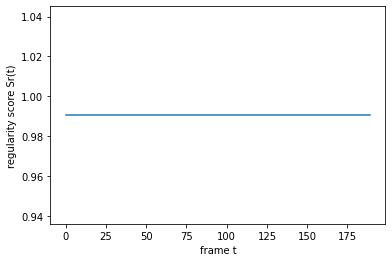

Epoch 2


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Test size:190


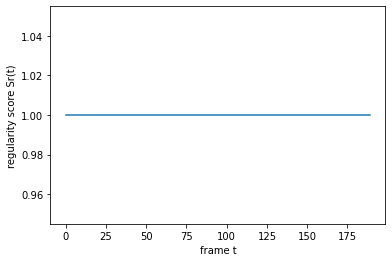

Epoch 3


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Test size:190


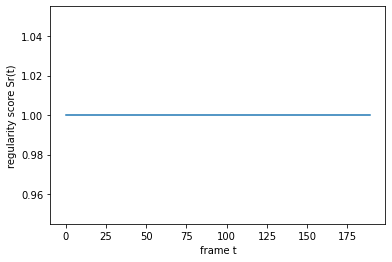

Epoch 4


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: ignored

In [8]:

test_cases_dir = "Test008"
test_cases = get_test_sequences(test_cases_dir, 200)
print("Test data set loaded")
conf.reconfig(new_name="Conv2DLSTM_WGAN_GP", batch_size=4, epochs=100, retrain=0)
x_train = get_clips_list(conf.dim1)

print("Train data set loaded")

batchsize = conf.BATCH_SIZE
j = 0
num_batches = int(len(x_train) / batchsize)
for epochnumber in range(conf.EPOCHS):
    j = j+1
    bar = IncrementalBar('Countdown', max = num_batches)
    print("Epoch "+str(j))
    for i in range(int(len(x_train) / batchsize)):

        settrainable(model_ae, True)
        settrainable(model_enc, True)
        settrainable(model_dec, True)
        
        batch = x_train[i*batchsize:i*batchsize+batchsize]
        model_ae.train_on_batch(batch, batch)
        
        settrainable(model_disc, True)
        batchpred = model_enc.predict(batch)
        fakepred = np.random.standard_normal((batchsize,20480))
        discbatch_x = np.concatenate([batchpred, fakepred])
        discbatch_y = np.concatenate([np.zeros(batchsize), np.ones(batchsize)])
        model_disc.train_on_batch(discbatch_x, discbatch_y)
        
        settrainable(model_enc_disc, True)
        settrainable(model_enc, True)
        settrainable(model_disc, False)
        model_enc_disc.train_on_batch(batch, np.ones(batchsize))
        bar.next()
        time.sleep(1)
    
    model_enc.save(conf.GEN_MODEL_PATH)
    model_dec.save(conf.DEC_MODEL_PATH)
    model_disc.save(conf.DIS_MODEL_PATH) 
    evaluate_gen(test_cases, model_ae, test_cases_dir, epochnumber)
    evaluate_dis(test_cases, model_enc_disc)
    print ("Reconstruction Loss:", model_ae.evaluate(x_train, x_train, verbose=0, batch_size=conf.BATCH_SIZE))
    print ("Adverserial Loss:", model_enc_disc.evaluate(x_train, np.ones(len(x_train)), verbose=0, batch_size=conf.BATCH_SIZE))


evaluate_gen(test_cases, model_ae, test_cases_dir)

evaluate_dis(test_cases, model_enc_disc)